# Calcular as anomalias mensais 

### Calcular as anomalias mensais para o ano de 2021 do ERA5, baseando-se na climatologia de 1991-2020

###  Importar as bibliotecas

In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import regionmask as rmk
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

C:\Users\igf_i\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
path_ERA5 = 'Dados_ERA5/ERA5_Prec_Month_BR_1991-2023.nc'
path_st = 'Serie_Temporal/'
path_shape_BR_regs = 'BR_Regioes/regioes.shp'
path_shape_BR = 'Brasil_Contorno/Brasil.shp'
path_out = 'Figuras/'

### Carregar o dataset

In [4]:
df_ERA5 = xr.load_dataset(path_ERA5) 

### Selecionar o período climatológico e das anomalias, e domínio espacial

In [5]:
#seleciona o período climatológico e recorta o domínio
df_BR_clim = df_ERA5.sel(time = slice('1991', '2020')).sel(latitude = slice(6, -36), longitude = slice(-77, -33)) 

In [7]:
#seleciona o período das anomalias e recorta o domínio
df_BR_anom = df_ERA5.sel(time = '2021').sel(latitude = slice(6, -36), longitude = slice(-77, -33)) 
df_BR_anom

<xarray.Dataset>
Dimensions:    (time: 12, longitude: 169, latitude: 165)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -33.5 -33.25 -33.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -34.5 -34.75 -35.0
Data variables:
    tp         (time, latitude, longitude) float32 0.001288 ... 0.004167
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Apr 08 08:45:59 2024: cdo -v -z zip -sellonlatbox,-75,-...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

### Calcular a climatologia mensal para 1991-2020

In [8]:
# mm/mês (conversão de unidades)
df_BR_clim = df_BR_clim * 1000 * df_BR_clim.time.dt.daysinmonth 

In [9]:
# cálculo da climatologia mensal
df_BR_clim = df_BR_clim.groupby('time.month').mean(dim = 'time') 

### Calcular as anomalias mensais para o ano de 2021 e selecionar a variável chuva do dataset

In [11]:
# mm/mês (conversão de unidades)
df_BR_anom = df_BR_anom * 1000 * df_BR_anom.time.dt.daysinmonth 

In [12]:
# Cálculo da anomalia mensal
df_BR_anom = df_BR_anom.groupby('time.month') - df_BR_clim 


In [13]:
# Seleção da variável chuva do dataset
prec_anom = df_BR_anom['tp'] 

### Mascarar a região desejada

In [14]:
# Abre o shapefile do Brasil
BR_shp = gpd.read_file(path_shape_BR) 

In [15]:
# load do shapefile para máscara
mask_BR = rmk.from_geopandas(BR_shp) 

In [16]:
# renomeia as coordenadas latitude e longitude para lat e lon
prec_anom = prec_anom.rename({'latitude': 'lat', 'longitude': 'lon'}) 


In [17]:
# aplica a máscara na variável de anomalia
prec_anom_mask = mask_BR.mask(prec_anom) 

In [18]:
# seleciona qual região mascarar (índice = 0)
prec_anom_mask_BR = prec_anom.where(prec_anom_mask == 0) 

### Plotar as anomalias mensais em forma de mapas como subplots em apenas 1 figura

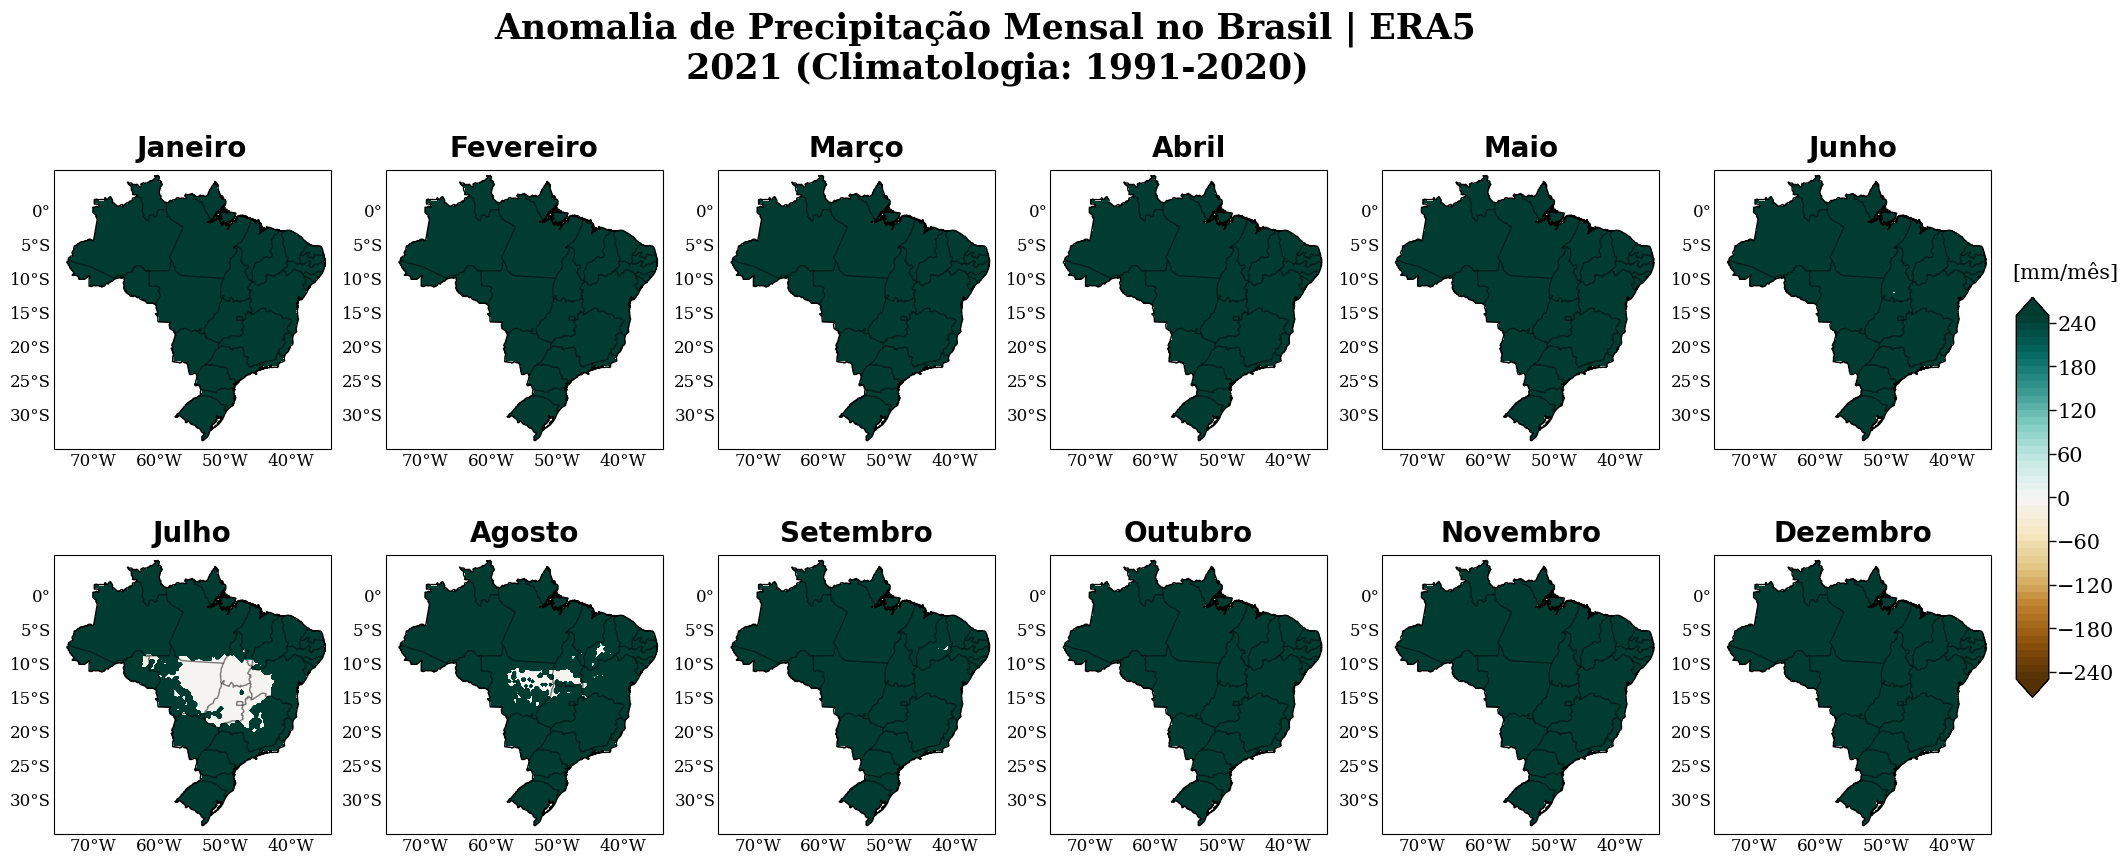

In [19]:
mon_list_name = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro'] #lista com os nomes dos meses

fig, axs = plt.subplots(2, 6, figsize = (25, 10), subplot_kw = dict(projection = ccrs.PlateCarree())) #criação da figura e subplots

axs_list = axs.ravel() #transforma o array das listas dos axs (eixos dos subplots da figura) para uma única lista

font_gl = {'size': 12,'color': 'black'} #dicionário com tamanho e cor da fonte de texto

plt.rcParams['font.family'] = 'serif' #parâmetro do tipo da fonte do texto

states = NaturalEarthFeature(category = 'cultural', scale = '50m', facecolor = 'none', name ='admin_1_states_provinces_lines') #shape dos estados do Brasil

for i in range(12): #looping para a quantidade de meses do plot de anomalias

    plot_anom = axs_list[i].contourf(prec_anom_mask_BR.lon, prec_anom_mask_BR.lat, prec_anom_mask_BR[i], transform = ccrs.PlateCarree(),
                                    cmap = 'BrBG', levels = np.arange(-250, 260, 10), extend = 'both') #plot da anomalia

    axs_list[i].add_feature(states, edgecolor = 'black', linewidth = 1, alpha = 0.5, linestyle = '-') #plot dos estados
    
    axs_list[i].set_xlim(left = -76, right = -34) #limite da longitude
    axs_list[i].set_ylim(bottom = -35, top = 6) #limite da latitude

    gl = axs_list[i].gridlines(crs = ccrs.PlateCarree(), draw_labels = True, alpha = 0) #tudo relacionado ao gl é sobre as linhas de grade da figura
    gl.top_labels = False
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xpadding = 2
    gl.ypadding = 2
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(-70, -30, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-30, 5, 5))
    gl.xlabel_style = font_gl
    gl.ylabel_style = font_gl

    BR_shp.plot(ax = axs_list[i], lw = 1, ec = 'black', fc = 'none') #plot do shape do Brasil
    
    #mon_name = calendar.month_name[i + 1]
    mon_name = mon_list_name[i] #mês do subplot capturando na lista criada
    
    axs_list[i].set_title(mon_name, fontsize = 20, fontweight = 'bold', pad = 10) #título de cada subplot

fig.suptitle('Anomalia de Precipitação Mensal no Brasil | ERA5 \n 2021 (Climatologia: 1991-2020)',
                x = 0.5, y = 0.95, ha = 'center', va = 'center', fontsize = 25, fontweight = 'bold') #título da figura

cbar_ax = fig.add_axes([0.91, 0.3, 0.013, 0.4]) #criação do eixo da escala de cor
cbar = plt.colorbar(plot_anom, cax = cbar_ax, orientation = 'vertical') #plot da escalar de cor na vertical
cbar.outline.set_linewidth(1) #parâmetro de espessura da linha da escala de cor
cbar.ax.tick_params(labelsize = 15, width = 1, length = 5, pad = 1) #parâmetros para mudar os ticks da escala

cbar_ax.text(1.5, 1.12, '[mm/mês]',
                  verticalalignment = 'center', horizontalalignment = 'center',
                  transform = cbar_ax.transAxes,
                  color = 'black', fontsize = 15,
                  fontweight = 'normal') #plot do texto da unidade próximo à escala de cor

plt.subplots_adjust(wspace = 0.2, hspace = 0) #ajuste na horizontal e vertical entre os subplots

plt.savefig(f'{path_out}Anom_Chuva_Mensal_2021_ERA5.jpeg', dpi = 600, bbox_inches = 'tight') #salva a figura